<center>Agustina Garcia Saenz, Javier Cejudo, David Gadyt, Thorsten Brückner<br>
<center>March 15, 2023<br><br><br>
<hr style="height:5px;border-width:0;color:orange;background-color:green">
<center><b><span style="font-size: 32px; color: green;"> Bob's Recommendation Task</b></span></center>

<a id="0"></a>
<font color=green size=+3><b>0 - Module Summary</b></font>

During the analysis phase, one of the points that was highlighted is that there is a problem with the engagement of the current client base. This can be seen in the average amount of products per client on a given month, which right now is below one, meaning that there are more customers without products than with products, while at the very least this ratio should be at one. This found issue aligns with the overall current strategy of the company, which is to reorient the commercial focus towards increasing the penetration of the product portfolio in the existing client base to increase profits rather than doing any other campaign for acquiring new customers.

Having this in mind, in order to recommend products to the current clientbase to maximize profitability out of it, there are several strategies to follow: one could be to place the focus on customers that have no products or customers that have one product. Another strategy could be to offer different products to our best clients. From a business point of view seems logic to make an effort on focusing on clients that have zero or one product, this would lead to an increase of the engagement of a very inactive client base which has larger potential benefit, not only in terms of customers that can be targetted but also for long term prospects. Prior to jump into fancy Machine Learning models, sa attempt should be made at manually characterize these customers and understand which products to offer them, as relevant information is already available from the analysis phase. Once this manual approach has been understood, it can be constrasted with results from a Machine Learning model that would yield probabilities of purchase for this manually chosen customers. This would set the ground for future improvement, tuning and scale up of models that can help the company to become Data driven.

This module will focus on the practical implementation of some of the aforemetioned ideas: manual selection of customers having the target of the company in mind, evaluation of the probabilities of these chosen customers to actually purchase the offered product together with the confidence interval associated to this probabilities and finally, the limitations of the model and possible steps towards the future. As a reminder: the Marketing department stated that the current budget allows only 10k mails to be sent, so the goal will be to maximize the potential revenue that can be gained out of them.

<a id="0.2"></a>
<font color=green size=+3><b>0.1 - Module Imports & Configurations</b></font>

In [1]:
## GENERAL USE
import pandas as pd
import numpy as np
import re # regular expressions
import tqdm # progress bar

## VISUALIZATION
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## MODELLING
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import recall_score, accuracy_score
from sklearn.dummy import DummyClassifier
import xgboost as xgb

# FORMAT
pd.options.display.float_format = '{:,.2f}'.format

c:\Users\javce\anaconda3\envs\nuclio_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<font color=green size=+3><b>0.1 - Data Import</b></font>

In [2]:
df = pd.read_csv('data/Bobs_df_delivery.csv', index_col=0)
df.head()

,pk_partition,country_id,region_code,gender,age,salary,short_term_deposit,loans,mortgage,funds,...,entry_date,entry_channel,active_customer,Total_products,year_partition,month_partition,year_month_partition,quarter_entry,year_month_entry,salary_LN
pk_cid,,,,,,,,,,,,,,,,,,,,,
1375586,2018-01-28,ES,Malaga,H,36,"87,218.10",0,0,0,0,...,2018-01-12,others,1,1,2018,1,2018-01,2018-Q1,2018-01,11.38
1050611,2018-01-28,ES,Ciudad Real,V,24,"35,548.74",0,0,0,0,...,2015-08-10,KHE,0,1,2018,1,2018-01,2015-Q3,2015-08,10.48
1050612,2018-01-28,ES,Ciudad Real,V,23,"122,179.11",0,0,0,0,...,2015-08-10,KHE,0,1,2018,1,2018-01,2015-Q3,2015-08,11.71
1050613,2018-01-28,ES,Zaragoza,H,23,"119,775.54",1,0,0,0,...,2015-08-10,KHD,0,1,2018,1,2018-01,2015-Q3,2015-08,11.69
1050614,2018-01-28,ES,Zaragoza,V,24,"89,257.08",0,0,0,0,...,2015-08-10,KHE,1,1,2018,1,2018-01,2015-Q3,2015-08,11.40


In [3]:
df.reset_index(inplace=True)

<a id="1"></a>
<font color=green size=+3><b>1 - Initial strategy: EM Account recommendation</b></font>

As it has been introduced, the assumption on which the following is based on is that the best strategy from a business point of view is to focus on customers that have certain level of engagement but no products, or just one. The idea behind is that to re-engage these customers and enlarge the proportion of active customers within the current clientbase of the company would be more benefitial than exploiting current active customers with already several products.

The overall strategy will be to start from simple and build on complexity based on our needs and resources at hand. Thus, the first step is the manual selection of the 10k customers that will receive a mail with a recommended product, followed by the, again manual, selection of the product to be offered. 

In order to evaluate this approach, a Machine Learning model will be built in order to statistically evaluate the probabilities and confidence of it. The model will be designed as a Supervised Learning problem, trained with the data provided by the IT department and used to assess the purchase likelihood of the selected customers. More details on the specific aspects of it can be found at section "1.3 - Probabilities of purchase - Supervised Learning Model".


<font color=green size=+3><b>1.1 - Manual selection of 10k customers</b></font>

Even though during the analysis it could be seen that there are concerns on how the "active_customer" feature is computed, it will still be used as an indicator of recent engagement with the company. In order to select the 10k customers, the first filter will be to check whether they have been active or not in the company application during the last partition of data, as it is believed that hey will be more likely to purchase a product than customers that have not been active. If in the future, the way of computing this feature is readjusted and improved, it will only have a beneficial impact on this approach.

The selection of final customers will be based on the following features: total revenue and months of activity. From the available data, which includes demographics, products owned and commercial activity, the overall revenue that a client has brought to Easy Money over its time as a client could be taken as a positive indicator of engagement and predisposition of re-engaging. In a similar fashion, from the commercial information, the total month of activity in the company's application can be used as a positive indicator of engagement.

An assumption that is made for the following calculation of the revenue brought by a customer is that the marketing unit prices equal to the expected revenue of a given customer that owns or uses the product for a given month. Together with it, it is assumed that even though a customer might appear inactive for a given partition, if the customer owns product during that month, the company will receive the expected revenue out of those products.

One last but crucial point is to make sure that only customers appearing in the last partition of the database are selected, so as to minimize the risk of targetting churned customers.






In [5]:
# First off, let's start by selecting only customers present in last month
target_id = df.loc[df['pk_partition']=='2019-05-28','pk_cid'].unique().tolist()
print(len(target_id))

440248


In [4]:
products = ['short_term_deposit', 'loans', 'mortgage', 'funds','securities', 'long_term_deposit', 'credit_card', 'payroll','pension_plan', 'payroll_account', 'emc_account', 'debit_card','em_acount']

In [6]:
# create a df to calculate revenue and activity, keep only meaningful features
target_info_df = pd.concat([df[['pk_partition','pk_cid']],df[products],df['active_customer']],axis=1)
# filter out clients not in target_id
target_info_df = target_info_df[target_info_df['pk_cid'].isin(target_id)]

In [7]:
len(target_info_df['pk_cid'].unique())

440248

In [8]:
target_info_df.columns

Index(['pk_partition', 'pk_cid', 'short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_acount', 'active_customer'],
      dtype='object')

The list of revenues as reported by Erin:
- €10 for each account
- €40 for savings and investment products (plans, funds,...)
- €60 for financing products (loans and cards)

In [9]:
# Taking into account the list above + the current order of columns of the active df:
revenues_list = [1,1,40,60,60,40,40,40,60,10,40,0,10,60,10,1]

In [10]:
target_info_df = target_info_df*revenues_list

In [11]:
# sum  column has the total revenue for each row in the dataframe
target_info_df.loc[:,'sum'] = target_info_df[products].sum(axis=1)
target_info_df.head()

,pk_partition,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,active_customer,sum
0,2018-01-28,1375586,0,0,0,0,0,0,0,0,0,0,0,0,10,1,10
1,2018-01-28,1050611,0,0,0,0,0,0,0,0,0,0,0,0,10,0,10
2,2018-01-28,1050612,0,0,0,0,0,0,0,0,0,0,0,0,10,0,10
3,2018-01-28,1050613,40,0,0,0,0,0,0,0,0,0,0,0,0,0,40
4,2018-01-28,1050614,0,0,0,0,0,0,0,0,0,0,0,0,10,1,10


In [12]:
target_info_df.isnull().sum()

pk_partition          0
pk_cid                0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
active_customer       0
sum                   0
dtype: int64

In [13]:
# Revenue: total revenue over time from each customer: product x revenue @ each partition
# Months: number of months the client has been active in the app.

customer_cumulative_info = target_info_df.groupby('pk_cid').agg({'sum': 'sum', 'active_customer': 'sum'})
customer_cumulative_info.columns = ['revenue', 'months']
customer_cumulative_info.to_csv('customer_cumulative_info.csv')
customer_cumulative_info.head()

,revenue,months
pk_cid,,
16063,0,5
16203,50,5
16502,130,8
17457,1110,17
17590,0,11


Above dataframe, customer_cumulative_info, has each unique customer id as index for rows and the total revenue and months of activity as features, which have been specifically computed for each customer.

In [14]:
customer_cumulative_info.shape

(440248, 2)

In [16]:
# customer_cumulative_info = pd.read_csv('customer_cumulative_info.csv',index_col=0)

In [15]:
customer_cumulative_info.sort_values(by='revenue', ascending=False,inplace=True)
customer_cumulative_info

,revenue,months
pk_cid,,
1128353,4880,17
1116675,4810,17
1136671,4670,17
1070525,4440,17
1133500,4420,17
...,...,...
1330066,0,0
1330062,0,0
1330060,0,0


In [103]:
customer_cumulative_info.describe()

,revenue,months
count,"430,248.00","430,248.00"
mean,231.44,5.30
std,375.39,7.08
min,0.00,0.00
25%,40.00,0.00
50%,170.00,0.00
75%,170.00,12.00
max,"4,880.00",17.00


In [108]:
customer_cumulative_info[customer_cumulative_info['months']==0].describe()

,revenue,months
count,"246,662.00","246,662.00"
mean,93.24,0.00
std,80.18,0.00
min,0.00,0.00
25%,0.00,0.00
50%,100.00,0.00
75%,170.00,0.00
max,"1,130.00",0.00


The table above shows clearly the problems that have been signaled regarding the identification of activity in the app: There are users which have never been active in the application, which is the only known way of purchasing and managing products, that own or have owned products.

The other two tables show that even though there are very good clients, which are active in the application and have been reporting a solid revenue to the company, there is a majority of users with very low levels of engagement with the company. The overal mean revenue is much higher than the median, indicating that there is a group of customers with high engagement that are pulling the numbers up. This information falls in line with the proposed strategy.

In [17]:
# Aux function to get list of products appearing as ones in a given row

def get_products(row):
    result = []
    index = row['pk_cid']
    for p in products:
        if row[p]==1:
            result.append(p)
    return [result,index]

In [18]:
# profile of products each customer has during last month
products_per_customer = df.loc[df['pk_partition']=='2019-05-28'].apply(get_products, axis=1)    
products_per_customer = products_per_customer.apply(pd.Series)
products_per_customer.columns = ['products', 'id']
products_per_customer.head()

,products,id
5485815,[em_acount],657826
5485816,[],657817
5485817,"[credit_card, payroll, pension_plan, payroll_a...",657986
5485818,"[long_term_deposit, em_acount]",657905
5485819,[em_acount],657336


In [19]:
products_per_customer.shape

(440248, 2)

In [20]:
products_per_customer.set_index('id', inplace=True)

In [21]:
customer_cumulative_info = pd.merge(customer_cumulative_info, products_per_customer, how='left', left_index=True, right_index=True)
customer_cumulative_info['products'].value_counts().head(10)

[em_acount]                                             255094
[]                                                      108751
[debit_card, em_acount]                                  22400
[emc_account, em_acount]                                  7825
[payroll, pension_plan, payroll_account, debit_card]      6009
[emc_account]                                             5745
[payroll_account]                                         4704
[payroll, pension_plan, payroll_account]                  4335
[payroll_account, debit_card]                             3109
[emc_account, debit_card, em_acount]                      2279
Name: products, dtype: int64

In [22]:
customer_cumulative_info['products_str'] = customer_cumulative_info['products'].astype('str')
customer_cumulative_info['products_str'] = customer_cumulative_info['products_str'].str.strip('[]').str.replace("'","")
len(customer_cumulative_info[customer_cumulative_info['products_str']==''])

108751

Again, it is visible that EM account is the most popular product amongst our customer base. What is concerning is that the second largest cluster in terms of collection of products in the current clientbase is people without products. 

It is also worth noting that debit card and emc account are not only the second and third most usual products, they also are the chosen products to complement EM account when a customer wants to expand his wallet options.

From the 108751 customers that have no products, the selection of 10k customers to be targetted with the mails will be made.
An initial filter will be to check whether these customers have been active in the application during the last available partition.

In [23]:
# which ones of them have been active last month?

index_group1 = df.loc[(df['pk_partition']=='2019-05-28')&(df['active_customer']==1)&(df['Total_products']==0), 'pk_cid'].unique()
len(index_group1)

2769

In [24]:
# remove these customers from the ranking and add them to the 10k list
df_10k_em = customer_cumulative_info[customer_cumulative_info.index.isin(index_group1)]
customer_cumulative_info = customer_cumulative_info[~customer_cumulative_info.index.isin(index_group1)]
print(len(customer_cumulative_info))
print(len(df_10k_em))
print(len(customer_cumulative_info) + len(df_10k_em))

437479
2769
440248


In [25]:
df_10k_em

,revenue,months,products,products_str
pk_cid,,,,
1045535,2430,16,[],
1116106,2260,17,[],
1020461,2260,17,[],
1119050,2030,17,[],
1209899,1950,17,[],
...,...,...,...,...
1312708,0,5,[],
1314286,0,11,[],
1313313,0,17,[],


There were only 2769 customers without product that were showing some signs of activity in the application. They have been selected because it is understood that higher signs of activity in the app would mean higher disposition for making a purchase.

For the remaining 7231 customers, the selection will be made giving priority to those customers with higher revenues over time and most time being active. It will be seen that there are customers that even though have not been active last month and currently have no products, have been active in the past and have had products. The assumption is that these customers would be easier to reengage that customers that have had less relation with the company in the past

In [26]:
customer_cumulative_info.loc[(customer_cumulative_info['products_str']=='')].sort_values(by=['revenue','months'], ascending=False)

,revenue,months,products,products_str
pk_cid,,,,
1250924,2030,16,[],
1126774,1880,15,[],
1195576,1840,14,[],
1320970,1820,16,[],
1016939,1740,10,[],
...,...,...,...,...
1330066,0,0,[],
1330062,0,0,[],
1330060,0,0,[],


In [27]:
group2 = customer_cumulative_info.loc[(customer_cumulative_info['products_str']=='')].sort_values(by=['revenue','months'], ascending=False).iloc[:7231]
index_group2 = group2.index.tolist()
customer_cumulative_info = customer_cumulative_info[~customer_cumulative_info.index.isin(index_group2)]

In [28]:
df_10k_em = pd.concat([df_10k_em,group2])

In [29]:
df_10k_em.drop(['products','products_str'], axis=1, inplace=True)
df_10k_em

,revenue,months
pk_cid,,
1045535,2430,16
1116106,2260,17
1020461,2260,17
1119050,2030,17
1209899,1950,17
...,...,...
1119048,50,0
1352778,50,0
1272462,50,0


All 10k customers have or have had relation with the company at some point.

<a id="1"></a>
<font color=green size=+3><b>1.2 - Manual Selection of product to offer</b></font>

During the analysis phase, it has been discussed why the main product of the company (EM account) is the most solid product of the company: the one that attracts more new customers and the one with better retention. Let's refresh the list of most popular product(s) this last month in the list of customers that we didn't select as the 10k.

In [30]:
customer_cumulative_info['products'].value_counts().head(10)

[em_acount]                                             255094
[]                                                       98751
[debit_card, em_acount]                                  22400
[emc_account, em_acount]                                  7825
[payroll, pension_plan, payroll_account, debit_card]      6009
[emc_account]                                             5745
[payroll_account]                                         4704
[payroll, pension_plan, payroll_account]                  4335
[payroll_account, debit_card]                             3109
[emc_account, debit_card, em_acount]                      2279
Name: products, dtype: int64

As seen above, most customers have only EM account, then we still have a great deal of customers that have no products. As it has been just mentioned, debit card and emc account seem to be the products of choice when a customer decides to purchase a second product, specially the former.

**Because of these reasons, the product of choice for the recommendation mail to be sent to the chosen 10k customers is EM account.**\
The next step will be to develop a Machine Learning model to assess the statistical probabilities of these customers making the actual purchase.

<a id="1"></a>
<font color=green size=+3><b>1.3 - Probabilities of purchase - Supervised Learning Model</b></font>

The selection of the target customers and product to offer has been the simplest possible and it is focused on engaging customers, in order to estimate estimate the probabilities of them actually purchasing an EM account, let's start with a basic model and proceed from the results. 

Therefore, the scope of this section is to discuss and put in practice the assembly of a supervised model to assess the success of the proposed mail campaign. The model will be trained with data from the latest list of customers in our database, the target to be predicted will be whether certain profiles of revenue and activity have an EM account or not. In order to add one more dimension to the data from where to draw patterns, age will be added as additional information, it is chosen because it seems the most reliable feature out of the ones available. Once the model meets the quality expectations, which are to be specified later on, the list of selected customers will be fed into te model to predict the probabilities of them purchasing an account or not.


The steps to follow will be:
1. Select features and prepare a dataframe that can be used to train and validate a model. This dataframe can in no way contain any info from the selected 10k customers to avoid data leakage. Note: The revenue and months calculated in previous steps will not be used. Because the problem is defined to predict the state during last partition, no info from this last partition will be used to train, test or validate it.
2. Train, test and validate the model with data from the clientbase.
3. Generate a confidence of interval via bootstraping our data.
4. Once the model meets the expectations, use it to assess the probabilities of our chosen list to purchase the proposed product.
5. Estimate a window of revenues to expect from this campaign.

The algorithm chose for building the model is XGBoost. \
**WHY**

#### Data preprocessing

In [31]:
# Recompute revenue and months w/o taking into account last partition
_aux_info_model_df = target_info_df[target_info_df.pk_partition != '2019-05-28']

In [32]:
em_model_df = _aux_info_model_df.groupby('pk_cid').agg({'sum': 'sum', 'active_customer': 'sum'})
em_model_df.columns = ['revenue', 'months']
em_model_df.head()

,revenue,months
pk_cid,,
16063,0,5
16203,40,4
16502,110,7
17457,1000,16
17590,0,10


In [33]:
em_model_df.shape

(435782, 2)

In [34]:
# the target will be the state of "em_acount" last month
EM_last_month = df.loc[df['pk_partition']=='2019-05-28',['pk_cid','em_acount']]
EM_last_month.set_index('pk_cid', inplace=True)

In [35]:
EM_last_month.shape

(440248, 1)

In [36]:
em_model_df = pd.merge(em_model_df, EM_last_month, how='left',left_index=True, right_index=True)

In [37]:
em_model_df.head()

,revenue,months,em_acount
pk_cid,,,
16063,0,5,0
16203,40,4,1
16502,110,7,1
17457,1000,16,1
17590,0,10,0


In [38]:
em_model_df.shape

(435782, 3)

In [39]:
# as said, age will be added as a one hot encoded feature so there is more information from where to draw patterns
df['age_cat'] = pd.cut(x=df['age'], bins=[0,18,30,40,50,60,70,80,110], labels=['u18','18-30','31-40','41-50','51-60','61-70','71-80','o80'])
df.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,salary,short_term_deposit,loans,mortgage,...,entry_channel,active_customer,Total_products,year_partition,month_partition,year_month_partition,quarter_entry,year_month_entry,salary_LN,age_cat
0,1375586,2018-01-28,ES,Malaga,H,36,"87,218.10",0,0,0,...,others,1,1,2018,1,2018-01,2018-Q1,2018-01,11.38,31-40
1,1050611,2018-01-28,ES,Ciudad Real,V,24,"35,548.74",0,0,0,...,KHE,0,1,2018,1,2018-01,2015-Q3,2015-08,10.48,18-30
2,1050612,2018-01-28,ES,Ciudad Real,V,23,"122,179.11",0,0,0,...,KHE,0,1,2018,1,2018-01,2015-Q3,2015-08,11.71,18-30
3,1050613,2018-01-28,ES,Zaragoza,H,23,"119,775.54",1,0,0,...,KHD,0,1,2018,1,2018-01,2015-Q3,2015-08,11.69,18-30
4,1050614,2018-01-28,ES,Zaragoza,V,24,"89,257.08",0,0,0,...,KHE,1,1,2018,1,2018-01,2015-Q3,2015-08,11.40,18-30


In [40]:
_aux_age = df.loc[df['pk_partition']=='2019-05-28',['pk_cid','age_cat']]
_aux_age.set_index('pk_cid', inplace=True)
# filter out clients that are not appearing
em_model_df = pd.merge(em_model_df, _aux_age, how='left',left_index=True, right_index=True)
em_model_df.head()

,revenue,months,em_acount,age_cat
pk_cid,,,,
16063,0,5,0,61-70
16203,40,4,1,61-70
16502,110,7,1,51-60
17457,1000,16,1,51-60
17590,0,10,0,51-60


In [41]:
# one hot encode the age categories
_dummy_df = pd.get_dummies(em_model_df['age_cat'], prefix='age')
em_model_df = pd.merge(em_model_df, _dummy_df, how='left',left_index=True, right_index=True)
em_model_df.drop('age_cat', axis=1, inplace=True)
em_model_df.head()


,revenue,months,em_acount,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80
pk_cid,,,,,,,,,,,
16063,0,5,0,0,0,0,0,0,1,0,0
16203,40,4,1,0,0,0,0,0,1,0,0
16502,110,7,1,0,0,0,0,1,0,0,0
17457,1000,16,1,0,0,0,0,1,0,0,0
17590,0,10,0,0,0,0,0,1,0,0,0


In [42]:
# make sure our 10k customers are not in the dataframe
index_10k_em = df_10k_em.index.tolist()
em_model_df = em_model_df[~em_model_df.index.isin(index_10k_em)]

In [43]:
# save
em_model_df.to_csv('em_model_df.csv')
df_10k_em.to_csv('df_10k_em.csv')

In [44]:
em_model_df.rename(columns={"em_acount": "target_em"}, inplace=True)

In [45]:
em_model_df.head()

,revenue,months,target_em,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80
pk_cid,,,,,,,,,,,
16063,0,5,0,0,0,0,0,0,1,0,0
16203,40,4,1,0,0,0,0,0,1,0,0
16502,110,7,1,0,0,0,0,1,0,0,0
17457,1000,16,1,0,0,0,0,1,0,0,0
17799,160,16,1,0,0,0,1,0,0,0,0


In [46]:
em_model_df['target_em'] = em_model_df['target_em'].astype('uint8')

In [47]:
em_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425894 entries, 16063 to 1548207
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   revenue    425894 non-null  int64
 1   months     425894 non-null  int64
 2   target_em  425894 non-null  uint8
 3   age_u18    425894 non-null  uint8
 4   age_18-30  425894 non-null  uint8
 5   age_31-40  425894 non-null  uint8
 6   age_41-50  425894 non-null  uint8
 7   age_51-60  425894 non-null  uint8
 8   age_61-70  425894 non-null  uint8
 9   age_71-80  425894 non-null  uint8
 10  age_o80    425894 non-null  uint8
dtypes: int64(2), uint8(9)
memory usage: 13.4 MB


The dataframe is now ready for the modelling

#### Split data

In [48]:
X_train_em, X_dev_em, y_train_em, y_dev_em = model_selection.train_test_split(
    em_model_df.drop('target_em',axis=1),
    em_model_df['target_em'],
    test_size=0.3,
    random_state=42
)

In [49]:
print(em_model_df.shape)
print(X_train_em.shape)
print(X_dev_em.shape)

(425894, 11)
(298125, 10)
(127769, 10)


In [50]:
X_test_em, X_val_em, y_test_em, y_val_em = model_selection.train_test_split(
    X_dev_em,
    y_dev_em,
    test_size = 0.5,
    random_state=42
)

In [51]:
print(X_test_em.shape)
print(X_val_em.shape)

(63884, 10)
(63885, 10)


#### Model

In [52]:
split_dict_em = {
    "TRAINING": [X_train_em, y_train_em],
    "TESTING": [X_test_em, y_test_em]
}

In [53]:
# instantiate model
xgb_model_em = xgb.XGBClassifier(
    eta = 0.1,
    max_depth = 45,
    min_child_weight = 0.5,
    gamma = 5,
    random_state = 42,
    verbosity=0,
    use_label_encoder=False
)

# train 
xgb_model_em.fit(X = X_train_em, y = y_train_em)

c:\Users\javce\anaconda3\envs\nuclio_env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, gamma=5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=45, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [109]:
print("################## EM ACCOUNT ##################")
print("____________ SCORES & EVALUATIONS ____________")
print("#################### RESULTS ###################\n")


for data in split_dict_em.items():
    pred = xgb_model_em.predict(data[1][0])
    confusion_matrix = metrics.confusion_matrix(data[1][1], pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Accuracy = metrics.accuracy_score(data[1][1], pred)
    Precision = metrics.precision_score(data[1][1], pred)
    Recall = metrics.recall_score(data[1][1], pred)
    F_1_Score = metrics.f1_score(data[1][1], pred)

    PPV, NPV = ((tp / (tp + fp)) * 100), ((tn / (fn + tn)) * 100)

    print(f"#################### {data[0]} ####################")
    print(f"Accuracy: {round(Accuracy, 5)} | Precision: {round(Precision, 5)} | Recall: {round(Recall, 5)} | F1_Score: {round(F_1_Score, 5)}")
    print(f"TN = {tn} | FN = {fn} | TP = {tp} | FP = {fp}")
    print(f"Positive prediction value: {round(PPV, 2)}% | Negative prediction value: {round(NPV, 2)}%")
    print("########## TOP FEATURES ##########")
    top_features = pd.Series(xgb_model_em.feature_importances_, index = data[1][0].columns).sort_values(ascending = False).head()
    print(top_features)
    print("\n")

################## EM ACCOUNT ##################
____________ SCORES & EVALUATIONS ____________
#################### RESULTS ###################

#################### TRAINING ####################
Accuracy: 0.9364 | Precision: 0.9417 | Recall: 0.96818 | F1_Score: 0.95475
TN = 79131 | FN = 6575 | TP = 200034 | FP = 12385
Positive prediction value: 94.17% | Negative prediction value: 92.33%
########## TOP FEATURES ##########
revenue     0.64
age_18-30   0.21
months      0.05
age_31-40   0.04
age_o80     0.01
dtype: float32


#################### TESTING ####################
Accuracy: 0.93239 | Precision: 0.93874 | Recall: 0.96486 | F1_Score: 0.95162
TN = 17089 | FN = 1547 | TP = 42476 | FP = 2772
Positive prediction value: 93.87% | Negative prediction value: 91.7%
########## TOP FEATURES ##########
revenue     0.64
age_18-30   0.21
months      0.05
age_31-40   0.04
age_o80     0.01
dtype: float32




In [110]:
# Baseline
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(X_test_em, y_test_em)
dummy_clf.predict(X_test_em)
round(dummy_clf.score(X_test_em, y_test_em), 2) 


0.69

**Results**

Due to the nature of the problem that is being tackled, identifying potential buyers, a False Negative is much more damaging to the company than a False Positive. The former would mean that we are not identifying as a buyer someone with higher chances of being so. False positives are also important because they would be targetted as buyers when they won't likely buy anything, but as long as the number of False Negatives is reduced to a minimum, a low proportion of False Negatives is not concerning. In order to evaluate this properly, the target metrics will be recall and accuracy.

Regarding the actual results, first of all a baseline has been set. This baseline is computed as the accuracy that would be obtained if we predict the target as only 1 (purchase). As it can be seen, our accuracy is much better than this, for both Training and Testing (93.6% and 93.2% respectively). Also, the most important metric in this problem, recall, has the best results of all of them: 96.8% and 96.5%. These are good indicators to move forward.

As for the top features, we see that revenue plays a very important role, perhaps too important and that months has only a marginal weight on the decision.

In [ ]:
# Grid search

params_xgb = {
        'eta': [0.05, 0.1, 0.3],
        'min_child_weight': [0.5, 1, 5],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [5, 10, 30, 45],
        'subsample': [0.8, 0.9, 1]
        }

grid_search_xgb = model_selection.GridSearchCV(
    estimator=xgb_model_em,
    param_grid=params_xgb,
    scoring='recall',
    cv=5,
    verbose=1
)

grid_search_xgb.fit(X_train_em, y_train_em)

print(grid_search_xgb.best_estimator_)

In [56]:
# validation data

y_val_pred_em = pd.DataFrame(xgb_model_em.predict(X_test_em), index = y_test_em.index, columns = ['pred'])
results_val_em = pd.DataFrame(y_test_em).join(y_val_pred_em, how = 'inner')

# metrics
Accuracy_val_em = metrics.accuracy_score(results_val_em['target_em'], results_val_em['pred'])
Precision_val_em = metrics.precision_score(results_val_em['target_em'], results_val_em['pred'])
Recall_val_em = metrics.recall_score(results_val_em['target_em'], results_val_em['pred'])
rf_f1_val_em = metrics.f1_score(y_test_em, y_val_pred_em)
print("Accuracy: ", Accuracy_val_em)
print("Precision: ", Precision_val_em)
print("Recall: ", Recall_val_em)
print("F1 score xgb: ",rf_f1_val_em)

Accuracy:  0.9323930874710412
Precision:  0.9387376237623762
Recall:  0.9648592781046271
F1 score xgb:  0.9516192268485847


The validation results are very consistent and in line with the trend from training and testing.\
One of the possible reasons for such good results is the amount of data that we have, more than 500k datarows for training, testing and validating. On the other hand, we might also have undetected overfitting: the number of features that we are using to build profiles is very limited and thus the output might not be as close to reality as we would like it to be. Models are simplifications of reality and because of this, they will always be limited, but more diverse data with good quality would help to build more reliable and robust models.

The next step will be now to build an interval of confidence in an attempt to assess the robustness of the model.

#### Interval of confidence

While it is true that the dataset that has been used is large and therefore there is some statistical relevance in the results, it is good practice to assess these results and calculate a confidence interval for them.

Since we do not have access to new data with the same conditions from the same source, in order to draw new datasets the method to follow will be sampling our own dataset with instances from itself to generate new bootstrap datasets.

The methodology is:
1. Create bootstrap dataset of the same size of the original dataset by drawing instances at random from the test set.
2. Genereate enough bootstrap datasets to achieve the desired level of confidence.
3. For each one of the bootstrap samples, calculate the target metrics.

As stated in the previous section, due to the nature of the problem at hand, the target metrics are accuracy and recall. 

In [57]:
# 1. Function to create one bootsrap dataset from the original one
def one_boot(*data_args):
    """Usage: (t, p) = one_boot(true, pred) with true, pred, t, p arrays of same length
    """
    length = len(data_args[0])
    index = np.random.randint(0, length, size=length)  # apply same sampled index to all args:
    return [pd.Series(arg.values[index], name=arg.name) if isinstance(arg, pd.Series) else arg[index] for arg in data_args]

# Compute metrics on passed data
def calc_metrics(metrics, *data_args):
    """Return a list of calculated values for each metric applied to *data_args
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3, m4]
    """
    metrics=_fix_metrics(metrics)
    mname = metrics.__name__ if hasattr(metrics, '__name__') else "Metric"
    return pd.Series([m(*data_args) for m in metrics], index=[_metric_name(m) for m in metrics], name=mname)

# aesthetics for __name__ of the metric
def _metric_name(metric):  
    name = re.sub(' score$', '', metric.__name__.replace('_',' ').strip())
    return name.title() if name.lower()==name else name

# Standardize metrics to always be a Series, no matter how many we have
# - if only one, list of one to Series
# - if multiple (already a list), to Series
def _fix_metrics(metrics_): # allow for single metric func or any iterable of metric funcs
    if callable(metrics_): metrics_=[metrics_]  # single metric func to list of one
    return pd.Series(metrics_)  # in case iterable metrics_ is generator, generate & store

# Progress bar
def trange(iterable):  
    return tqdm.trange(iterable, bar_format="{l_bar}{bar:30}{r_bar}{bar:-10b}")

# Generator of N boots
def _boot_generator(*data_args, nboots): #return Gener of boot sampl datasets, not huge list!
    return (one_boot(*data_args) for _ in trange(nboots)) # generator expression

# Metrics for N boots coming from our data
def raw_metric_samples(metrics, *data_args, nboots):
    """Return dataframe containing metric(s) for nboots boot sample datasets
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    metrics=_fix_metrics(metrics)
    _boot_gen = _boot_generator(*data_args, nboots=nboots) # boot gen es un cambio que he introducido yo
    cols=[calc_metrics(metrics, *boot_data) for boot_data in _boot_gen if boot_data[0].nunique() >1]
    return pd.DataFrame({iboot: col for iboot,col in enumerate(cols)}).rename_axis("Boot", axis="columns").rename_axis(cols[0].name)

# Compute number of boots depending on the desired confidence of interval
def _min_nboots_from(alpha):
    return int(np.ceil((MIN_BOOTS_IN_1TAIL - 1)/(0.5*alpha) + 1)) 
def _min_alpha_from(nboots):
    return 2 * (MIN_BOOTS_IN_1TAIL - 1) / (nboots - 1)

# Default alpha = 0.05, meaning our default desired CI is 95%
DFLT_ALPHA = 0.05     
# With the following parameter we can define how many boots we need to have in the tails of the 
# distribution in order to ensure we get our desired level of confidence. This value comes from literature.
MIN_BOOTS_IN_1TAIL=11 
MAX_ALPHA = 0.40 
MIN_NBOOTS = _min_nboots_from(MAX_ALPHA)

# compute the nboots for our given alpha (1- CI)
def get_alpha_nboots(alpha=DFLT_ALPHA, nboots=None):
    """Return (alpha, nboots) with default nboots, applying MIN_NBOOTS & min alpha for nboots.
    """
    if alpha > MAX_ALPHA and (0 < (1-alpha) <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} > 0.5. Did you mean alpha={1-alpha:.9g}?')
    elif not (0 < alpha <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} is outside allowed range: 0 < alpha <= {MAX_ALPHA}')
    if pd.isna(nboots):   # by dflt use calculated min nboots for given alpha:
        nboots = _min_nboots_from(alpha)
    if int(nboots) != nboots: raise ValueError(f"nboots={nboots} isn't an integer")
    nboots = max(int(nboots), MIN_NBOOTS)  # apply min to a specified OR calculated nboots
    alpha = max(alpha, _min_alpha_from(nboots))  # apply min alpha for final nboots
    return (alpha, nboots)  # tuple of possibly-modified args

# Histogram of bootstrap sample dataset showing confidence interval only of Balanced Accuracy
def metric_boot_histogram(metric, *data_args, alpha=DFLT_ALPHA, nboots=None, ax=None):
    """Plot histogram w/ lines for 1 observed metric & its confidence interval.
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots) # 1-row df 2 series:
    series = raw_metric_samples(metric, *data_args, nboots=nboots).iloc[0,:]
    nboots=len(series) # in case some failed
    (lo, hi) = series.quantile([0.5*alpha, 1 - 0.5*alpha])
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(series, bins=50, alpha=0.4, edgecolor='white')
    showing = f"\n for {100*(1-alpha):.4g}% Confidence Interval"
    ax.set_title(f"Result of {nboots} boots" + showing)
    ax.set_xlabel(series.name)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    for x in lo, metric(*data_args), hi:
        ax.plot([x, x], [0, nboots*.07], lw=2.5)

# confidence interval for all list of metrics
def ci_auto( metrics, *data_args, alpha=DFLT_ALPHA, nboots=None):
    """Return Pandas data frame of bootstrap confidence intervals. 
    PARAMETERS:
    metrics : a metric func or iterable of funcs e.g. [m1, m2, m3]
    data_args : 1+ (often 2, e.g. ytrue,ypred) iterables for metric 
    alpha: = 1 - confidence level; default=0.05 i.e. confidence=0.95
    nboots (optional!): # boots drawn from data; dflt None ==> calc. from alpha
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots)
    metrics=_fix_metrics(metrics)
    result=raw_metric_samples(metrics, *data_args, nboots=nboots)
    nb=result.shape[1]  # num boots we ended up with
    if nb<nboots:
        t = f'Note: {nboots-nb} boot sample datasets dropped\n'
        print(t + f'(out of {nboots}) because all vals were same in 1st data arg.')
    result = result.apply(lambda row: row.quantile([0.5*alpha, 1 - 0.5*alpha]), axis=1)
    result.columns = [f'{x*100:.4g}%ile' for x in (0.5*alpha, 1 - 0.5*alpha)]
    result.insert(0, "Observed", calc_metrics(metrics, *data_args)) # col. for obs (point estim)
    return result.rename_axis(f"%ile for {nb} Boots", axis="columns")

100%|██████████████████████████████| 401/401 [00:07<00:00, 56.06it/s]


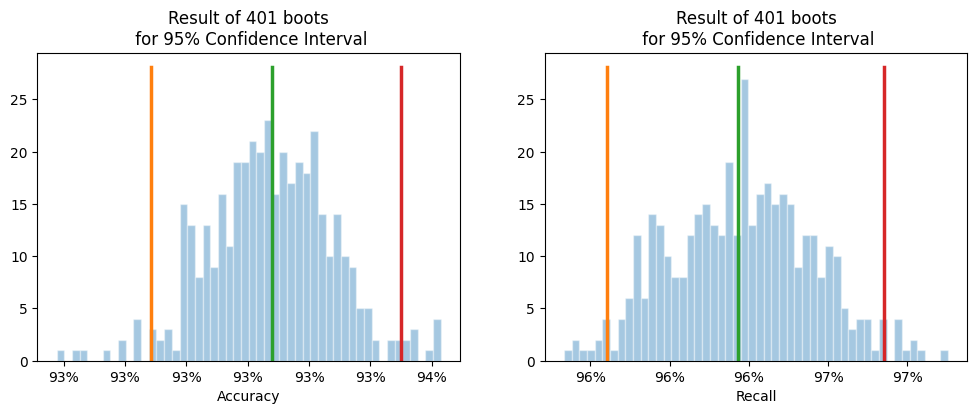

In [58]:
np.random.seed(42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# CI for Accuracy
metric_boot_histogram(accuracy_score, results_val_em['target_em'], results_val_em['pred'], ax=ax1)
# CI for Recall
metric_boot_histogram(recall_score, results_val_em['target_em'], results_val_em['pred'], ax=ax2)
plt.show()

In [59]:
# Define metrics
met=[recall_score, accuracy_score]

# calculate Confidence interval
np.random.seed(42)
ci_auto(met, results_val_em['target_em'], results_val_em['pred']).style.format('{:.2%}') # y = target, the other value is the category we are actually predicting

100%|██████████████████████████████| 401/401 [00:08<00:00, 46.34it/s]


%ile for 401 Boots,Observed,2.5%ile,97.5%ile
Metric,,,
Recall,96.49%,96.31%,96.65%
Accuracy,93.24%,93.04%,93.45%


The results are outstanding. The very narrow intervals of confidence are due to the massive amount of datapoints, which helps to draw statistically significant results.

The model is ready to assess the selection of 10k customers.

#### Evaluation of the 10k chosen customers

In [60]:
# add the ages
df_10k_em = pd.merge(df_10k_em, _aux_age, how='left', left_index=True, right_index=True)
# one hot encode the ages
_dummy_df = pd.get_dummies(df_10k_em['age_cat'], prefix='age')
df_10k_em = pd.merge(df_10k_em, _dummy_df, how='left',left_index=True, right_index=True)
df_10k_em.drop('age_cat', axis=1, inplace=True)
df_10k_em.head()


,revenue,months,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80
pk_cid,,,,,,,,,,
1045535,2430,16,0,0,1,0,0,0,0,0
1116106,2260,17,0,0,0,1,0,0,0,0
1020461,2260,17,0,0,1,0,0,0,0,0
1119050,2030,17,0,0,1,0,0,0,0,0
1209899,1950,17,0,0,1,0,0,0,0,0


In [63]:
proba_em = xgb_model_em.predict_proba(df_10k_em)
proba_em_df = pd.DataFrame(data = proba_em, index=index_10k_em, columns=['class1','class2'])
df_10k_em = pd.merge(df_10k_em, proba_em_df['class2'], how='left',left_index=True, right_index=True)
df_10k_em


,revenue,months,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80,class2
pk_cid,,,,,,,,,,,
1045535,2430,16,0,0,1,0,0,0,0,0,0.13
1116106,2260,17,0,0,0,1,0,0,0,0,0.33
1020461,2260,17,0,0,1,0,0,0,0,0,0.22
1119050,2030,17,0,0,1,0,0,0,0,0,0.52
1209899,1950,17,0,0,1,0,0,0,0,0,0.26
...,...,...,...,...,...,...,...,...,...,...,...
1119048,50,0,0,1,0,0,0,0,0,0,0.86
1352778,50,0,0,0,1,0,0,0,0,0,0.62
1272462,50,0,0,1,0,0,0,0,0,0,0.86


In [64]:
df_10k_em[df_10k_em['class2']>0.5]

,revenue,months,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80,class2
pk_cid,,,,,,,,,,,
1119050,2030,17,0,0,1,0,0,0,0,0,0.52
1185828,1180,17,0,0,0,1,0,0,0,0,0.51
1239232,1120,17,0,0,0,0,1,0,0,0,0.95
1260310,1120,17,0,0,1,0,0,0,0,0,0.96
1261703,1120,17,0,1,0,0,0,0,0,0,0.95
...,...,...,...,...,...,...,...,...,...,...,...
1119048,50,0,0,1,0,0,0,0,0,0,0.86
1352778,50,0,0,0,1,0,0,0,0,0,0.62
1272462,50,0,0,1,0,0,0,0,0,0,0.86


In [65]:
len(set(index_group1) & set(df_10k_em[df_10k_em['class2']>0.5].index.to_list()))

# Actually only 653 customers out of the 2769 seem to have more than random probabilities of purchasing the account

653

In [66]:
df_10k_em['class2'].describe()

count   10,000.00
mean         0.65
std          0.34
min          0.02
25%          0.41
50%          0.78
75%          0.96
max          1.00
Name: class2, dtype: float64

Comments 

Calculate revenue range out of this + interval of confidence?

<a id="1"></a>
<font color=green size=+3><b>2 - Alternative strategy: Debit card recommendation</b></font>

It has been seen already several times that the most popular product to go together with an EM account is the debit card, which also happens to be one of the products which bring most revenue to the company. Now that a baseline model and results have been established, the goal will be to improve upon them. To do so, now a new target group of 10k customers will be defined, which will focus on customers that already have an EM account but no debit card. 

The process will be the same as for the previous section, with the difference that the product to recommend is already defined:
- Manual selection of the 10k customers
- Build a Supervised Learning problem with the same objective: calculate probabilities of purchase.



<font color=green size=+3><b>2.1 - Manual selection of 10k customers</b></font>

In [67]:
# selection of the 10k from the same customer base
customer_cumulative_info_dc = target_info_df.groupby('pk_cid').agg({'sum': 'sum', 'active_customer': 'sum'})
customer_cumulative_info_dc.columns = ['revenue', 'months']
customer_cumulative_info_dc.to_csv('customer_cumulative_info_dc.csv')
customer_cumulative_info_dc.head()

,revenue,months
pk_cid,,
16063,0,5
16203,50,5
16502,130,8
17457,1110,17
17590,0,11


In [68]:
customer_cumulative_info_dc.shape

(440248, 2)

In [69]:
customer_cumulative_info_dc = pd.merge(customer_cumulative_info_dc, products_per_customer, how='left', left_index=True, right_index=True)
customer_cumulative_info_dc['products'].value_counts().head(10)

[em_acount]                                             255094
[]                                                      108751
[debit_card, em_acount]                                  22400
[emc_account, em_acount]                                  7825
[payroll, pension_plan, payroll_account, debit_card]      6009
[emc_account]                                             5745
[payroll_account]                                         4704
[payroll, pension_plan, payroll_account]                  4335
[payroll_account, debit_card]                             3109
[emc_account, debit_card, em_acount]                      2279
Name: products, dtype: int64

In [70]:
customer_cumulative_info_dc['products_str'] = customer_cumulative_info_dc['products'].astype('str')
customer_cumulative_info_dc['products_str'] = customer_cumulative_info_dc['products_str'].str.strip('[]').str.replace("'","")

A total of 255095 customers appear in the last partition owning an EM account.From this pool the selection of 10k will be drawn.

As a first filter, activity in the app:

In [71]:
# which ones of them have been active last month??
index_recommend_debit_card = df.loc[(df['pk_partition']=='2019-05-28')&(df['active_customer']==1)&(df['em_acount']==1)&(df['Total_products']==1), 'pk_cid'].unique()
len(index_recommend_debit_card)

94195

Having so many, the final selection can be drawn out of this group directly by taking into account total revenue and months of activity.

In [72]:

df_10k_debit_card = customer_cumulative_info_dc[customer_cumulative_info_dc.index.isin(index_recommend_debit_card)]
# get the best 10k
df_10k_debit_card = df_10k_debit_card.sort_values(by=['revenue','months'], ascending=False).iloc[:10000]
# Remove the 10k from the df for training
index_10k_debit_card = df_10k_debit_card.index
customer_cumulative_info_dc = customer_cumulative_info_dc[~customer_cumulative_info_dc.index.isin(index_10k_debit_card)]
print(len(customer_cumulative_info_dc))
print(len(df_10k_debit_card))
print(len(customer_cumulative_info_dc) + len(df_10k_debit_card))


430248
10000
440248


<font color=green size=+3><b>2.2 - Probabilities of purchase - Supervised Learning Model</b></font>

#### Data preprocessing

In [77]:
debit_card_model_df = _aux_info_model_df.groupby('pk_cid').agg({'sum': 'sum', 'active_customer': 'sum'})
debit_card_model_df.columns = ['revenue', 'months']
debit_card_model_df.head()

,revenue,months
pk_cid,,
16063,0,5
16203,40,4
16502,110,7
17457,1000,16
17590,0,10


In [78]:
DC_last_month = df.loc[df['pk_partition']=='2019-05-28',['pk_cid','debit_card']]
DC_last_month.set_index('pk_cid', inplace=True)

In [79]:
debit_card_model_df = pd.merge(debit_card_model_df, DC_last_month, how='left',left_index=True, right_index=True)
debit_card_model_df.head()

,revenue,months,debit_card
pk_cid,,,
16063,0,5,0
16203,40,4,0
16502,110,7,0
17457,1000,16,1
17590,0,10,0


In [80]:
# again, age will be added as a one hot encoded feature so there is more information from where to draw patterns

debit_card_model_df = pd.merge(debit_card_model_df, _aux_age, how='left',left_index=True, right_index=True)
# one hot encode the age categories
_dummy_df = pd.get_dummies(debit_card_model_df['age_cat'], prefix='age')
debit_card_model_df = pd.merge(debit_card_model_df, _dummy_df, how='left',left_index=True, right_index=True)
debit_card_model_df.drop('age_cat', axis=1, inplace=True)
debit_card_model_df.head()

,revenue,months,debit_card,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80
pk_cid,,,,,,,,,,,
16063,0,5,0,0,0,0,0,0,1,0,0
16203,40,4,0,0,0,0,0,0,1,0,0
16502,110,7,0,0,0,0,0,1,0,0,0
17457,1000,16,1,0,0,0,0,1,0,0,0
17590,0,10,0,0,0,0,0,1,0,0,0


In [81]:
# make sure our 10k customers are not in the dataframe
debit_card_model_df = debit_card_model_df[~debit_card_model_df.index.isin(index_10k_debit_card)]

In [82]:
debit_card_model_df.rename(columns={"debit_card": "target_dc"}, inplace=True)
debit_card_model_df['target_dc'] = debit_card_model_df['target_dc'].astype('uint8')
debit_card_model_df.head()

,revenue,months,target_dc,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80
pk_cid,,,,,,,,,,,
16063,0,5,0,0,0,0,0,0,1,0,0
16203,40,4,0,0,0,0,0,0,1,0,0
16502,110,7,0,0,0,0,0,1,0,0,0
17457,1000,16,1,0,0,0,0,1,0,0,0
17590,0,10,0,0,0,0,0,1,0,0,0


#### Split data

In [83]:
X_train_dc, X_dev_dc, y_train_dc, y_dev_dc = model_selection.train_test_split(
    debit_card_model_df.drop('target_dc',axis=1),
    debit_card_model_df['target_dc'],
    test_size=0.3,
    random_state=42
)

In [84]:
print(debit_card_model_df.shape)
print(X_train_dc.shape)
print(X_dev_dc.shape)

(425782, 11)
(298047, 10)
(127735, 10)


In [85]:
X_test_dc, X_val_dc, y_test_dc, y_val_dc = model_selection.train_test_split(
    X_dev_dc,
    y_dev_dc,
    test_size = 0.5,
    random_state=42
)

In [86]:
print(X_test_dc.shape)
print(X_val_dc.shape)

(63867, 10)
(63868, 10)


#### Model

In [87]:
split_dict_dc = {
    "TRAINING": [X_train_dc, y_train_dc],
    "TESTING": [X_test_dc, y_test_dc]
}

In [88]:
# instantiate model
xgb_model_dc = xgb.XGBClassifier(
    eta = 0.1,
    max_depth = 45,
    min_child_weight = 0.5,
    gamma = 5,
    random_state = 42,
    verbosity=0,
    use_label_encoder=False
)

# train 
xgb_model_dc.fit(X = X_train_dc, y = y_train_dc)

c:\Users\javce\anaconda3\envs\nuclio_env\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, gamma=5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=45, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [ ]:
# Grid search

params_xgb = {
        'eta': [0.05, 0.1, 0.3],
        'min_child_weight': [0.5, 1, 5],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [10, 30, 45],
        'subsample': [0.8, 0.9, 1]
        }

grid_search_xgb = model_selection.GridSearchCV(
    estimator=xgb_model_dc,
    param_grid=params_xgb,
    scoring='recall',
    cv=5,
    verbose=1
)

grid_search_xgb.fit(X_train_dc, y_train_dc)

print(grid_search_xgb.best_estimator_)

In [115]:
print("################## DEBIT CARD ##################")
print("____________ SCORES & EVALUATIONS ____________")
print("#################### RESULTS ###################\n")


for data in split_dict_dc.items():
    pred = xgb_model_dc.predict(data[1][0])
    confusion_matrix = metrics.confusion_matrix(data[1][1], pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Accuracy = metrics.accuracy_score(data[1][1], pred)
    Precision = metrics.precision_score(data[1][1], pred)
    Recall = metrics.recall_score(data[1][1], pred)
    F_1_Score = metrics.f1_score(data[1][1], pred)
    
    PPV, NPV = ((tp / (tp + fp)) * 100), ((tn / (fn + tn)) * 100)

    print(f"#################### {data[0]} ####################")
    print(f"Accuracy: {round(Accuracy, 5)} | Precision: {round(Precision, 5)} | Recall: {round(Recall, 5)} | F1_Score: {round(F_1_Score, 5)}")
    print(f"TN = {tn} | FN = {fn} | TP = {tp} | FP = {fp}")
    print(f"Positive prediction value: {round(PPV, 2)}% | Negative prediction value: {round(NPV, 2)}%")
    print("########## TOP FEATURES ##########")
    top_features = pd.Series(xgb_model_dc.feature_importances_, index = data[1][0].columns).sort_values(ascending = False).head()
    print(top_features)
    print("\n")

################## DEBIT CARD ##################
____________ SCORES & EVALUATIONS ____________
#################### RESULTS ###################

#################### TRAINING ####################
Accuracy: 0.96502 | Precision: 0.82998 | Recall: 0.82172 | F1_Score: 0.82583
TN = 262907 | FN = 5362 | TP = 24715 | FP = 5063
Positive prediction value: 83.0% | Negative prediction value: 98.0%
########## TOP FEATURES ##########
revenue     0.51
months      0.15
age_18-30   0.11
age_31-40   0.09
age_41-50   0.05
dtype: float32


#################### TESTING ####################
Accuracy: 0.96173 | Precision: 0.81732 | Recall: 0.80503 | F1_Score: 0.81113
TN = 56175 | FN = 1271 | TP = 5248 | FP = 1173
Positive prediction value: 81.73% | Negative prediction value: 97.79%
########## TOP FEATURES ##########
revenue     0.51
months      0.15
age_18-30   0.11
age_31-40   0.09
age_41-50   0.05
dtype: float32




In [90]:
# validation data
y_val_pred_dc = pd.DataFrame(xgb_model_dc.predict(X_test_dc), index = y_test_dc.index, columns = ['pred'])
results_val_dc = pd.DataFrame(y_test_dc).join(y_val_pred_dc, how = 'inner')

# metrics
Accuracy_val_dc = metrics.accuracy_score(results_val_dc['target_dc'], results_val_dc['pred'])
Precision_val_dc = metrics.precision_score(results_val_dc['target_dc'], results_val_dc['pred'])
Recall_val_dc = metrics.recall_score(results_val_dc['target_dc'], results_val_dc['pred'])
rf_f1_val_dc= metrics.f1_score(y_test_dc, y_val_pred_dc)
print("Accuracy: ", Accuracy_val_dc)
print("Precision: ", Precision_val_dc)
print("Recall: ", Recall_val_dc)
print("F1 score xgb: ",rf_f1_val_dc)

Accuracy:  0.9617329763414596
Precision:  0.8173181747391373
Recall:  0.8050314465408805
F1 score xgb:  0.8111282843894899


Training accuracy: 0.96502, recall: 0.82172\
Testing accuracy: 0.96173, recall: 0.80503\
Validation accuracy: 0.96173, recall: 0.80503

Again the results are very good, they are worse than for EM account but that would most likely be because the dataset is very imbalanced in terms of products. Any other product that is not EM account appears less in the database antd therefore, as a rarer product is chosen for the assessment the more difficult will be to obtain good metrics.

One point that has to be made is that the metrics for testing are validation are too similar. This is an indicator that we do not have enough variety in the sample that have been drawn for the modelling phase. If the company wants to move forward and scale up the complexity and the quality of the models used, actions should be taken to gather data with more quality, so other features can be used in order to build profiles.

#### Interval of confidence

100%|██████████████████████████████| 401/401 [00:06<00:00, 64.32it/s]


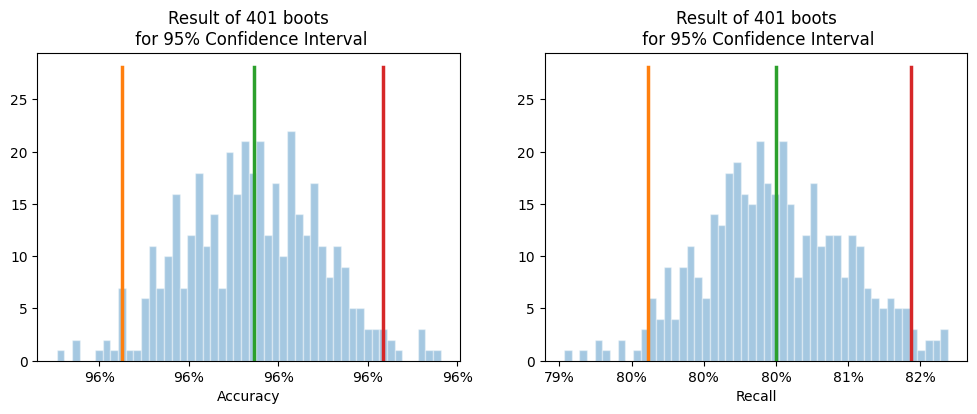

In [95]:
np.random.seed(42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# CI for Accuracy
metric_boot_histogram(accuracy_score, results_val_dc['target_dc'], results_val_dc['pred'], ax=ax1)
# CI for Recall
metric_boot_histogram(recall_score, results_val_dc['target_dc'], results_val_dc['pred'], ax=ax2)
plt.show()

In [96]:
# calculate Confidence interval
np.random.seed(42)
ci_auto(met, results_val_dc['target_dc'], results_val_dc['pred']).style.format('{:.2%}') 

100%|██████████████████████████████| 401/401 [00:07<00:00, 53.74it/s]


%ile for 401 Boots,Observed,2.5%ile,97.5%ile
Metric,,,
Recall,80.50%,79.61%,81.48%
Accuracy,96.17%,96.03%,96.32%


Similarly to the previous model, the confidence interval is quite narrow and might lead to think that the model is robust. However, the simplicity of the model needs to be taken into account, specially in the fact that the number and variety of features with which it has been trained was very limited. Therefore, even though the population is large enough as of to allow to obtain statistically relevant results, there might be a problem of underlying undetected overfitting.

#### Evaluation of our 10k chosen customers


In [97]:
# drop non usegul features
df_10k_debit_card.drop(['products','products_str'], axis=1, inplace=True)
# add the ages
df_10k_debit_card = pd.merge(df_10k_debit_card, _aux_age, how='left', left_index=True, right_index=True)
# one hot encode the ages
_dummy_df = pd.get_dummies(df_10k_debit_card['age_cat'], prefix='age')
df_10k_debit_card = pd.merge(df_10k_debit_card, _dummy_df, how='left',left_index=True, right_index=True)
df_10k_debit_card.drop('age_cat', axis=1, inplace=True)
df_10k_debit_card.head()


,revenue,months,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80
pk_cid,,,,,,,,,,
1003790,1920,17,0,0,1,0,0,0,0,0
1002266,1850,17,0,0,1,0,0,0,0,0
1074816,1790,17,0,0,1,0,0,0,0,0
1248233,1760,17,0,0,0,1,0,0,0,0
1251877,1690,17,0,0,0,1,0,0,0,0


In [99]:
proba_dc = xgb_model_dc.predict_proba(df_10k_debit_card)
proba_dc_df = pd.DataFrame(data = proba_dc, index = index_10k_debit_card, columns=['class1','class2'])
df_10k_debit_card = pd.merge(df_10k_debit_card, proba_dc_df['class2'], how='left',left_index=True, right_index=True)
df_10k_debit_card

,revenue,months,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80,class2
pk_cid,,,,,,,,,,,
1003790,1920,17,0,0,1,0,0,0,0,0,0.94
1002266,1850,17,0,0,1,0,0,0,0,0,0.93
1074816,1790,17,0,0,1,0,0,0,0,0,0.93
1248233,1760,17,0,0,0,1,0,0,0,0,0.95
1251877,1690,17,0,0,0,1,0,0,0,0,0.83
...,...,...,...,...,...,...,...,...,...,...,...
1298732,180,17,0,0,1,0,0,0,0,0,0.07
1301589,180,17,0,0,1,0,0,0,0,0,0.07
1312931,180,17,0,1,0,0,0,0,0,0,0.06


In [100]:
df_10k_debit_card[df_10k_debit_card['class2']>0.5]

,revenue,months,age_u18,age_18-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-80,age_o80,class2
pk_cid,,,,,,,,,,,
1003790,1920,17,0,0,1,0,0,0,0,0,0.94
1002266,1850,17,0,0,1,0,0,0,0,0,0.93
1074816,1790,17,0,0,1,0,0,0,0,0,0.93
1248233,1760,17,0,0,0,1,0,0,0,0,0.95
1251877,1690,17,0,0,0,1,0,0,0,0,0.83
...,...,...,...,...,...,...,...,...,...,...,...
1492114,190,7,0,1,0,0,0,0,0,0,0.60
1495241,190,7,0,1,0,0,0,0,0,0,0.60
1503010,190,7,0,1,0,0,0,0,0,0,0.60


In [101]:
df_10k_debit_card['class2'].describe()

count   10,000.00
mean         0.31
std          0.22
min          0.01
25%          0.14
50%          0.24
75%          0.42
max          0.98
Name: class2, dtype: float64

Comments

Calculate revenue range out of this + interval of confidence?

<a id="1"></a>
<font color=green size=+3><b>3 - Limitations</b></font>

data. reliability of available features\
model

Limitations: numbers of features we use ti build the profiles (revenue, months, age)
The model described above is very basic... etc and is only aimed at.
Future iterations of it can focus on...

training, testing, validation,.. similarities in data split and thus such good results. Effect of old/recent data, not ncecesarily.

feature importance: revenue months age

Resample the data somehow to overcome the lack of variety

<a id="1"></a>
<font color=green size=+3><b>4 - Conclusions and future steps</b></font>

(more tailored model w/ collaborative filtering to see which of them go together) and best selection of 10k


In [102]:
# based on expected revenue maybe better second step 

In [ ]:
# another option, do not prefilter and use all these customers as "new data", select the 10k with best rate response